In [710]:
import os
import sys

# Go one level up from 'notebooks/' to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Set PYTHONPATH environment variable
os.environ["PYTHONPATH"] = project_root

# Also update sys.path so Python knows to look there for imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Optional: verify
print("PYTHONPATH =", os.environ["PYTHONPATH"])

PYTHONPATH = c:\Users\shich\Src\thesis\hand_emg_regression


In [711]:
from emg_hand_tracking.dataset import load_recordings

d = load_recordings("../datasets/s1.z")

frames = d[7][-1].frames

Loading dataset: 100%|██████████| 17/17 [00:00<00:00, 29.10it/s]


In [712]:
from emg2pose.kinematics import forward_kinematics, load_default_hand_model
import numpy as np
import torch

hand_model = load_default_hand_model()

POINTS_SELECT = [5, 6, 7, 0, 8, 9, 10, 1, 11, 12, 13, 2, 14, 15, 16, 3, 17, 18, 19, 4]


# x: B, C
def forward_hand_kinematics(x: torch.Tensor | np.ndarray):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    hands = forward_kinematics(x.unsqueeze(1).permute(0, 2, 1), hand_model).squeeze(1)
    return hands[:, POINTS_SELECT, :]  # B, L, 3

In [713]:
import numpy as np
import torch


def rotation_matrix_from_vectors(
    vec1: torch.Tensor,
    vec2: torch.Tensor,
    eps: float = 1e-6,
) -> torch.Tensor:
    a = vec1 / vec1.norm()
    b = vec2 / vec2.norm()
    v = torch.cross(a, b, dim=-1)
    if v.norm() < eps:
        return torch.eye(3, dtype=vec1.dtype, device=vec1.device)
    c = torch.dot(a, b)
    s = v.norm()
    K = torch.tensor(
        [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]],
        dtype=vec1.dtype,
        device=vec1.device,
    )
    R = torch.eye(3, dtype=vec1.dtype, device=vec1.device)
    return R + K + K @ K * ((1 - c) / (s * s))


def normalize_hand(
    hand_3d_points: torch.Tensor | np.ndarray,
    whrist_base: int = 0,
    middle_finger_inner_bone: int = 8,
    point_finger_inner_bone: int = 4,
    eps: float = 1e-6,
) -> torch.Tensor:
    """
    Normalize one hand (L,3) or a batch of hands (B, L, 3):
      1. translate so point `whrist_base` is at the origin
      2. rotate so `middle_finger_inner_bone` aligns with +Y
      3. scale so that vector to `middle_finger_inner_bone` has length 1
      4. rotate around Y so `point_finger_inner_bone` lies in the +Z half-plane
    Returns same shape as input.
    """
    if not isinstance(hand_3d_points, torch.Tensor):
        hand_3d_points = torch.tensor(hand_3d_points, dtype=torch.float32)

    # if batch of hands, just loop
    if hand_3d_points.dim() == 3:
        B, L, _ = hand_3d_points.shape
        normalized = torch.empty_like(hand_3d_points)
        for b in range(B):
            # recursive call on each (L,3)
            normalized[b] = normalize_hand(
                hand_3d_points[b],
                whrist_base,
                middle_finger_inner_bone,
                point_finger_inner_bone,
                eps,
            )
        return normalized

    # --- below is the original single‑hand logic for shape (L,3) ---
    device, dtype = hand_3d_points.device, hand_3d_points.dtype

    # 1) translate so wrist base → origin
    T = -hand_3d_points[whrist_base]
    hand = hand_3d_points + T

    # 2) rotate so that middle finger inner bone aligns with +Y
    target_y = torch.tensor([0, 1, 0], dtype=dtype, device=device)
    R1 = rotation_matrix_from_vectors(hand[middle_finger_inner_bone], target_y, eps=eps)
    hand = hand @ R1.T

    # 3) scale so middle‐finger inner bone length → 1
    hand = hand / (hand[middle_finger_inner_bone][1] + eps)

    # 4) rotate around Y so the point finger inner bone lies in +Z half-plane
    v = hand[point_finger_inner_bone]
    xz = torch.stack([v[0], v[2]])
    norm_xz = xz.norm()
    if norm_xz >= eps:
        sinA, cosA = xz[0] / norm_xz, xz[1] / norm_xz
        R2 = torch.tensor(
            [[cosA, 0.0, -sinA], [0.0, 1.0, 0.0], [sinA, 0.0, cosA]],
            dtype=dtype,
            device=device,
        )
        hand = hand @ R2.T

    return hand

In [714]:
import time
import matplotlib.pyplot as plt
import torch


def inverse_hand_kinematics(y, x_init=None, show_plots=False):
    # y: B, L, 3

    scaler = 10.0

    if show_plots:
        start_time = time.time()

    y = scaler * normalize_hand(y)

    B, L = y.shape[0], y.shape[1]
    C = 20

    if x_init is not None:
        x = x_init.clone().detach().to(y.device).requires_grad_(True)
    else:
        x = torch.zeros(B, C, device=y.device, requires_grad=True)

    # lr estimated from initial error
    y_hat = scaler * normalize_hand(forward_hand_kinematics(x))
    mx_s_err = ((y_hat - y) ** 2).sum(dim=-1).max()
    mx_err = mx_s_err.sqrt()
    mx_s_err = mx_s_err.item()

    optimizer = torch.optim.NAdam([x], lr=mx_s_err * 0.005)
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=0.1,
        total_iters=6,
    )

    err_history = []
    lr_history = []
    mx_history = []

    for _ in range(6):
        optimizer.zero_grad()
        y_hat = scaler * normalize_hand(forward_hand_kinematics(x))
        loss = ((y_hat - y) ** 2).sum(dim=-1).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()

        mx_err = ((y_hat - y) ** 2).sum(dim=-1).max().sqrt().item()

        if show_plots:
            err_history.append(loss.sqrt().item())
            lr_history.append(optimizer.param_groups[0]["lr"])
            mx_history.append(mx_err)

        if mx_err < 1:
            break

    if show_plots:
        elapsed = (time.time() - start_time) * 1000  # type: ignore
        fps = y.shape[0] / (elapsed / 1000)

        print(
            f"time = {int(elapsed)}ms, fps = {fps:.2f}, final rmse = {err_history[-1]:.2f}, final max err={mx_err:.2f}"
        )

        # Plot max error progression
        plt.figure(figsize=(6, 4))
        plt.plot(mx_history, label="Max Error")
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Max Error")
        plt.title(f"Max Error Progression")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot error progression
        plt.figure(figsize=(6, 4))
        plt.plot(err_history, label="RMSE")
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.title(f"Error Progression")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot LR schedule
        if scheduler:
            plt.figure(figsize=(6, 2))
            plt.plot(lr_history, label="LR")
            plt.xlabel("Iteration")
            plt.ylabel("Learning Rate")
            plt.title(f"LR Schedule")
            plt.tight_layout()
            plt.show()

    return x

In [715]:
from random import randint

i = randint(0, 40)

landmarks = forward_hand_kinematics(frames[i : i + 1])
landmarks = landmarks + torch.randn_like(landmarks) * 3.0
landmarks.shape

torch.Size([1, 20, 3])

time = 38ms, fps = 26.16, final rmse = 1.03, final max err=1.96


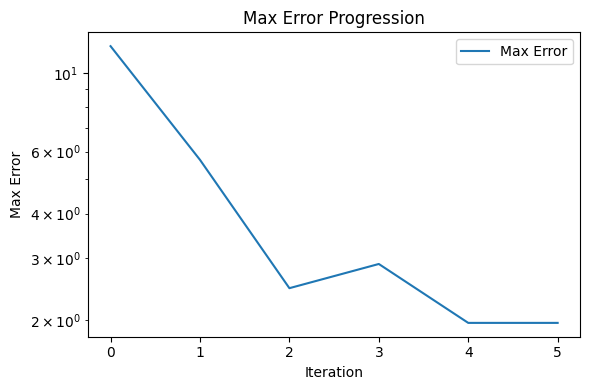

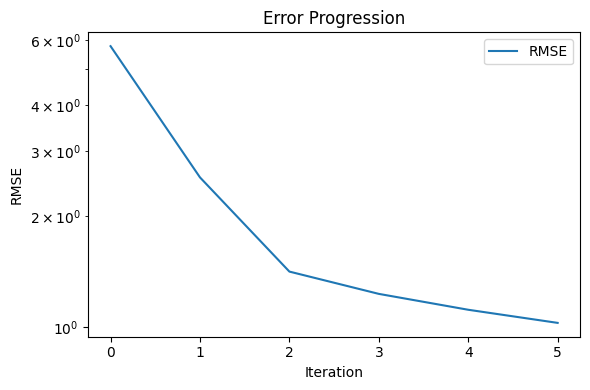

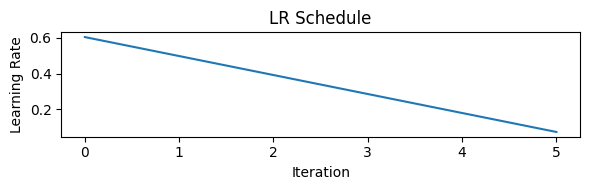

torch.Size([1, 20])

In [716]:
angles = inverse_hand_kinematics(landmarks, show_plots=True)
angles.shape

In [717]:
import plotly.graph_objects as go
import numpy as np
import torch


def plot_3d_hand(landmarks: torch.Tensor | np.ndarray):
    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.detach().cpu().numpy()

    fig = go.Figure()
    n_pts = landmarks.shape[0]
    labels = [str(i) for i in range(n_pts)]

    # Plot landmarks as 3D markers + text labels
    fig.add_trace(
        go.Scatter3d(
            x=landmarks[:, 0],
            y=landmarks[:, 1],
            z=landmarks[:, 2],
            mode="markers+text",
            marker=dict(size=4, color="blue"),
            text=labels,
            textposition="top center",
            textfont=dict(size=8, color="black"),
            name="Landmarks",
        )
    )

    connections = [
        (0, 1),
        (1, 2),
        (2, 3),  # Thumb
        (0, 4),
        (4, 5),
        (5, 6),
        (6, 7),  # Index
        (0, 8),
        (8, 9),
        (9, 10),
        (10, 11),  # Middle
        (0, 12),
        (12, 13),
        (13, 14),
        (14, 15),  # Ring
        (0, 16),
        (16, 17),
        (17, 18),
        (18, 19),  # Pinky
        # Palm
        (1, 4),
        (4, 8),
        (8, 12),
        (12, 16),
    ]

    # Plot connections (lines) between the landmarks
    for i, j in connections:
        fig.add_trace(
            go.Scatter3d(
                x=[landmarks[i, 0], landmarks[j, 0]],
                y=[landmarks[i, 1], landmarks[j, 1]],
                z=[landmarks[i, 2], landmarks[j, 2]],
                mode="lines",
                line=dict(color="black", width=2),
                showlegend=False,
            )
        )

    fig.update_layout(
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
        title="3D Hand Pose with Point Labels",
        margin=dict(l=0, r=0, b=0, t=30),
    )

    fig.show()

In [718]:
# verify they are the same

plot_3d_hand(normalize_hand(landmarks.squeeze(0)))
plot_3d_hand(normalize_hand(forward_hand_kinematics(angles).squeeze(0)))